# Analysis of Hospital Readmission Rates

## Introduction:

This notebook aims to describe a basical Machine Learning methodology. Following the previous session, we are going to learn a model to predict the risk of hospital readmission.

#  Data

Before we dive into machine learning, we’re going to explore a dataset, and figure out what might be interesting to predict.

- 101,766 patients hospitalization records.

- The Health Facts data I used was an extract representing 10 years (1999–2008) of clinical care at 130 hospitals

We download the dataset from the UCI Machine Learning Repository, another great sources of free data.:

In [1]:
from IPython.display import IFrame
IFrame('http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#', width=1000, height=350)

Firstly, we should load all dependancies:

In [1]:
%matplotlib inline

import time

# Import the pandas library.
import pandas as pd
print pd.__version__
# Import the numpy library.
import numpy as np

# Import the sklearn library.
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.feature_extraction import DictVectorizer as DV

# Import datavisualisation libraries.
import matplotlib.pyplot as plt
import seaborn

0.18.1


Secondly, we are loading dataset. Pandas is a very convenient data analysis package for data exploration and feature engineering.

In [3]:
# Read in the data.
df = pd.read_csv("/home/charles-abner/Documents/dataset_diabetes/diabetic_data.csv")
print(df.shape) #we take a look on the dimension

(101766, 50)


In [4]:
print df.head()

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital    ...     citoglipton insulin  glyburide-metformin  \
0                 1    ...              No      No         

##  Data Cleansing

We can access a column is a dataframe with Pandas using df["readmitted"]. This will extract a single column from the dataframe. Let’s plot a histogram of this column so we can visualize the distribution of targets. We’ll use Matplotlib to generate the visualization. Matplotlib is the main plotting infrastructure in Python, and most other plotting libraries, like seaborn and ggplot2 are built on top of Matplotlib. 

Axes(0.125,0.125;0.775x0.775)


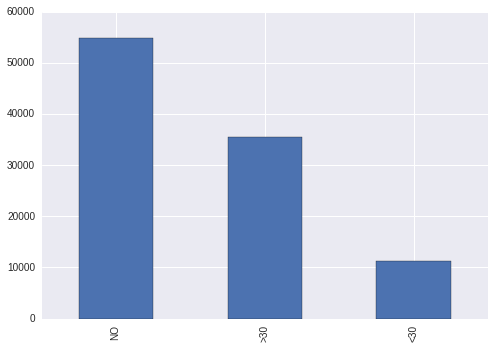

In [6]:
target = np.unique(df["readmitted"], return_inverse=True)
print df["readmitted"].value_counts().plot(kind='bar')

Let’s clean it up the data set and drop a few columns. We remove one class to convert multiclass issue into a binary classification. 

In [7]:
#Drop useless variables
df = df.drop(['encounter_id','patient_nbr'], axis=1)

# transform all "?" to NA
df = df.replace('?', np.nan)

print(df.head())

#we remove row contain ">30"
df = df[df["readmitted"]!=">30"]

#we extract target values
y = df['readmitted']
print df.dtypes

              race  gender      age weight  admission_type_id  \
0        Caucasian  Female   [0-10)    NaN                  6   
1        Caucasian  Female  [10-20)    NaN                  1   
2  AfricanAmerican  Female  [20-30)    NaN                  1   
3        Caucasian    Male  [30-40)    NaN                  1   
4        Caucasian    Male  [40-50)    NaN                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        25                    1                 1        NaN   
1                         1                    7                 3        NaN   
2                         1                    7                 2        NaN   
3                         1                    7                 2        NaN   
4                         1                    7                 1        NaN   

          medical_specialty     ...      citoglipton  insulin  \
0  Pediatrics-Endocrinology     ...               No     

We should get information about data type to convert string in categorical variables...

In [127]:
df.dtypes[0:10]

race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
dtype: object

We would controle how categorical variables are represented. We are going to dummify some variable with type object. get_dummies creates a new DataFrame with binary indicator variables for each category/option in the column specified. Once that's done, we merge the new dummy columns into the original dataset.

In [8]:

colsToDummify = ["medical_specialty","gender","weight","admission_type_id","discharge_disposition_id","race","age"]
df_dummies = df
for col in colsToDummify:
    print col + ' has been dummyfied'
    dummies = pd.get_dummies(df_dummies[col]).rename(columns=lambda x: col + '_' + str(x))
    df_dummies.drop([col], inplace=True, axis=1)
    df_dummies = pd.concat([df_dummies, dummies], axis=1)


medical_specialty has been dummyfied
gender has been dummyfied
weight has been dummyfied
admission_type_id has been dummyfied
discharge_disposition_id has been dummyfied
race has been dummyfied
age has been dummyfied


In [9]:
print(df_dummies.shape)
df_dummies.head()


(66221, 168)


,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,...,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
0,1,1,NaN,41,0,1,0,0,0,250.83,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,2,NaN,11,5,13,2,0,1,648,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,2,NaN,44,1,16,0,0,0,8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,1,NaN,51,0,8,0,0,0,197,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,2,4,NaN,70,1,21,0,0,0,414,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Data Exploration

In  the one hand, we analyze numerical features. We compute some descriptive statistics to get more information about distribution, value ranges, extrema values...

In [11]:
df.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,66221.000000,66221.000000,66221.000000,66221.000000,66221.000000,66221.000000,66221.000000,66221.000000,66221.000000,66221.000000,66221.000000
mean,2.021307,3.904894,5.641398,4.342550,42.697921,1.388110,15.881790,0.301204,0.151765,0.526374,7.302215
std,1.419133,5.492587,4.062932,2.982172,19.720143,1.723031,8.384629,1.083986,0.746954,1.172518,1.985369
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,4.000000,7.000000,6.000000,56.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,40.000000,64.000000,21.000000,16.000000


Correlation Analysis on numerical variables:

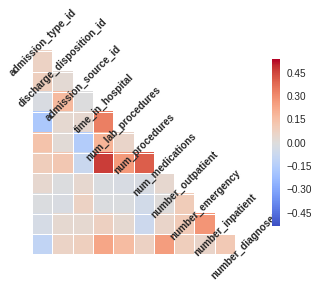

In [131]:
cols = [col for col in df.columns if col not in ['encounter_id']]
msk = (df.dtypes == 'int64')
plt.figure()
_ = seaborn.corrplot(df.loc[:,msk], annot=False)

In  the one hand, on discrete features, we plot histogram.

In [189]:
i=0
msk = (df.dtypes == object)
for (i,m) in enumerate(msk):
    if m and i<10:
        i+=1
        plt.figure()
        df.iloc[:, i].value_counts().plot(kind='bar')

Count Missing Value in the dataset:

In [133]:
print (df.count() / len(df))*100

race                         97.379985
gender                      100.000000
age                         100.000000
weight                        2.547530
admission_type_id           100.000000
discharge_disposition_id    100.000000
admission_source_id         100.000000
time_in_hospital            100.000000
payer_code                   60.091210
num_lab_procedures          100.000000
num_procedures              100.000000
num_medications             100.000000
number_outpatient           100.000000
number_emergency            100.000000
number_inpatient            100.000000
diag_1                       99.974328
diag_2                       99.571133
diag_3                       98.361547
number_diagnoses            100.000000
max_glu_serum               100.000000
A1Cresult                   100.000000
metformin                   100.000000
repaglinide                 100.000000
nateglinide                 100.000000
chlorpropamide              100.000000
glimepiride              

## Feature Engineering:

Here, we could compute some feature to extract more information from data. We can compute brute force features such as interaction, quadratic interaction, pca components... We can also compute feature with a business motivation.

## T-SNE

We use a technique called "t-SNE" that visualizes high-dimensional data by giving each
datapoint a location in a two map. It is a non linear dimension reduction method.

In [13]:
from sklearn.manifold import TSNE

In [14]:
n = 2000
msk = (df.dtypes == 'int64')
X = np.array(df.loc[:,msk])
X = X[1:n,:]
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tsne= model.fit_transform(X) 

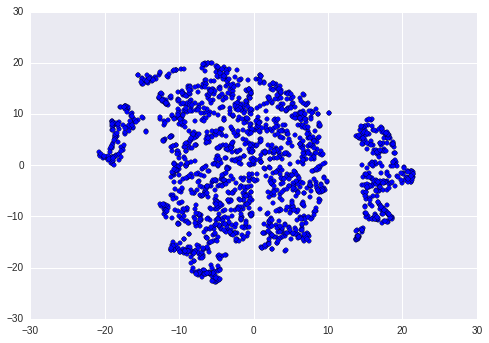

In [15]:
## -- plot t-sne
from matplotlib import pyplot as plt
# plot the result
vis_x = tsne[:, 0]
vis_y = tsne[:, 1]
plt.scatter(vis_x, vis_y)
plt.show()

## K-means

We’ll use a particular type of clustering called k-means clustering. Scikit-learn has an excellent implementation of k-means clustering that we can us. In order to use the clustering algorithm in Scikit-learn, we’ll first intialize it using two parameters – n_clusters defines how many clusters of games that we want, and random_state is a random seed we set in order to reproduce our results later

In [137]:
# Firstly, we convert all non numeric value into numeric
msk = (df.dtypes == object)
for (i,m) in enumerate(msk):
    if m:
        df.iloc[:, i] = np.unique(df.iloc[:, i], return_inverse=True)[1]
        

In [138]:
# Import the kmeans clustering model.
from sklearn.cluster import KMeans

# Initialize the model with 2 parameters -- number of clusters and random state.
kmeans_model = KMeans(n_clusters=3, random_state=1)
# Get only the numeric columns from df.
good_columns = df._get_numeric_data()
# Fit the model using the good columns.
kmeans_model.fit(good_columns)
# Get the cluster assignments.
labels = kmeans_model.labels_

## Plotting clusters with a PCA

Now that we have cluster labels, let’s plot the clusters. One sticking point is that our data has many columns So we’ll have to reduce the dimensionality of our data, without losing too much information. Dimensionality reduction techniques like PCA are widely used when preprocessing data for machine learning algorithms.

We’ll try to turn our  data into two dimensions, or columns, so we can easily plot it out.

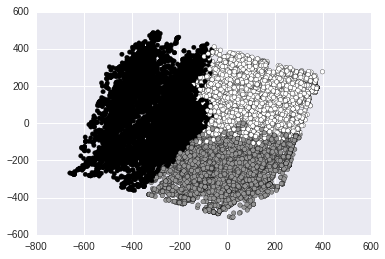

In [139]:
# Import the PCA model.
from sklearn.decomposition import PCA

# Create a PCA model.
pca_2 = PCA(2)
# Fit the PCA model on the numeric columns from earlier.
plot_columns = pca_2.fit_transform(good_columns)
# Make a scatter plot of each game, shaded according to cluster assignment.
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
# Show the plot.
plt.show()

# Figuring out what to predict

There are two things we need to determine before we jump into machine learning – how we’re going to measure error, and what we’re going to predict.

Concerning the error metric, we face a binary classification. There are a large variety of error metrics, but we can choose the most common for binary classification : AUC ("Area Under Curve")

In [140]:
from IPython.display import IFrame
IFrame('http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics', width=1000, height=350)

## Splitting into train and test sets


In order to prevent overfitting, we’ll train our algorithm on a set consisting of 80% of the data, and test it on another set consisting of 20% of the data. To do this, we first randomly samply 80% of the rows to be in the training set, then put everything else in the testing set.

In [141]:
# Import a convenience function to split the sets.
from sklearn.cross_validation import train_test_split

#Set random_state to be able to replicate results.
import random
random.seed(9001)

# Generate the training set.  
train = df.sample(frac=0.8, random_state=1)
train_dummies = df_dummies.sample(frac=0.8, random_state=1)


# Select anything not in the training set and put it in the testing set.
test = df.loc[~df.index.isin(train.index)]
test_dummies = df_dummies.loc[~df.index.isin(train.index)]


# Print the shapes of both sets.
print(train.shape)
print(test.shape)


#we define columns for features and target
columns = df.columns[:-1]
target = 'readmitted'


(52977, 47)
(13244, 47)


Above, we exploit the fact that every Pandas row has a unique index to select any row not in the training set to be in the testing set.

## Fitting a linear regression

Linear regression is a powerful and commonly used machine learning algorithm. It predicts the target variable using linear combinations of the predictor variables. 

Linear regression is a commonly used machine learning method. It predicts the target variable using linear combinations of the predictor variables. Let’s say we have a 2 values, 3, and 4. A linear combination would be 3 * .5 + 4 * .5. A linear combination involves multiplying each number by a constant, and adding the results.

In [152]:
# Import the linear regression model.
from sklearn.linear_model import LinearRegression

# Initialize the model class.
model = LinearRegression()

# Fit the model to the training daata.
model.fit(train[columns], train[target])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Compute predictor error

In [153]:
# Import the scikit-learn function to compute error.
from sklearn.metrics import roc_auc_score

# Generate our predictions for the test set.
predictions = model.predict(test[columns])

# Compute error between our test predictions and the actual values.
print roc_auc_score(test['readmitted'],predictions)


0.688861164426


## Interpreting the results

In [177]:
# Get coefficient for linear regression
model.coef_

array([-0.08027939, -0.07760214, -0.03941559, -0.02522421, -0.02237287,
       -0.01079942, -0.00724514, -0.00693759, -0.00655587, -0.00358147,
       -0.00352064, -0.00337855, -0.00309502, -0.00216484, -0.00086541,
       -0.00073029, -0.00014112, -0.00005383, -0.00000351, -0.        ,
       -0.        , -0.        ,  0.        ,  0.00001877,  0.00002855,
        0.00018929,  0.00102895,  0.00107599,  0.00112575,  0.00233188,
        0.00617352,  0.00623536,  0.0067997 ,  0.00764652,  0.00791633,
        0.00961947,  0.01231337,  0.01518206,  0.02523865,  0.0763926 ,
        0.08954018,  0.0955571 ,  0.11519391,  0.14607968,  0.15374307,
        0.17386938])

Axes(0.125,0.125;0.775x0.775)


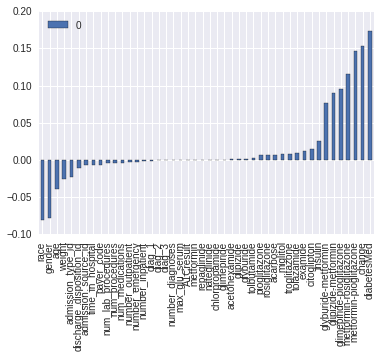

In [178]:
# Plot coefficient for linear regression
print pd.DataFrame(index=columns,data=model.coef_).plot(kind='bar')


## Fitting a logistic Regression

In [180]:
# Import the logistic model.
from sklearn.linear_model import LogisticRegression

# Initialize the model class.
model = LogisticRegression(solver='liblinear',penalty='l1',verbose=1)

# Fit the model to the training daata.
model.fit(train[columns], train[target])

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1)

In [181]:
# Generate our predictions for the test set.
predictions = model.predict(test[columns])

# Compute error between our test predictions and the actual values.
roc_auc_score(test['readmitted'],predictions)

0.54160908877647074

## Fitting a  Random Forest

In [182]:
# Import the random forest model.
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with some parameters.
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=1,verbose=1)
# Fit the model to the data.
model.fit(train[columns], train[target])
# Make predictions.
predictions = model.predict(test[columns])

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   22.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.7s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [183]:
# Compute error between our test predictions and the actual values.
roc_auc_score(test['readmitted'],predictions)

0.72334097248813622

## Fitting a Gradient Tree Boosting

Gradient Tree Boosting or Gradient Boosted Regression Trees (GBRT) is a generalization of boosting to arbitrary differentiable loss functions

In [185]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model with some parameters.
model = GradientBoostingClassifier(n_estimators=1000,loss='deviance',learning_rate=1.0,max_depth=1, random_state=0,verbose=1)
# Fit the model to the data.
model.fit(train[columns], train[target])
# Make predictions.
predictions = model.predict(test[columns])

      Iter       Train Loss   Remaining Time 
         1           0.8778            2.63m
         2           0.8713            1.69m
         3           0.8662            1.39m
         4           0.8617            1.20m
         5           0.8585            1.08m
         6           0.8539           59.78s
         7           0.8511           56.31s
         8           0.8489           55.54s
         9           0.8447           53.72s
        10           0.8428           52.11s
        20           0.8300           44.49s
        30           0.8236           41.75s
        40           0.8200           39.91s
        50           0.8160           38.68s
        60           0.8139           37.70s
        70           0.8124           36.88s
        80           0.8111           36.15s
        90           0.8098           35.52s
       100           0.8087           34.94s
       200           0.8027           30.12s
       300           0.7999           26.03s
       40

In [186]:
# Compute error between our test predictions and the actual values.
roc_auc_score(test['readmitted'],predictions)

0.55813837690731827

##  Further exploration

Here are some ideas for further exploration:
    - Try a support vector machine.
    - Generate features 

# References

-http://pandas.pydata.org/ # Documentation Library Pandas

-http:// numpy.pydata.org/ # Documentation Library Numpy

-http://scikit-learn.org/ # Documentation Library Scikit-learn

-https://ducquangworks.wordpress.com/2015/04/04/hospital-readmissions-analysis/

-https://www.dataquest.io/blog/getting-started-with-machine-learning-python/